## Feed forward NN

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

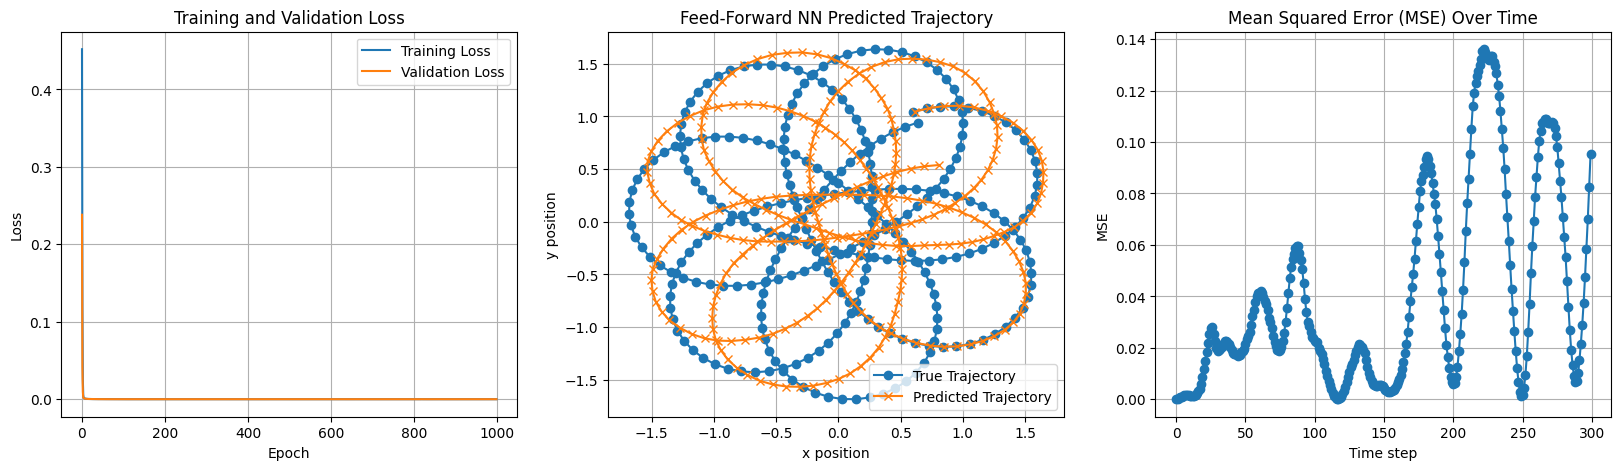

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import FeedForwardNN, RecurrentNN
from train import train_model, evaluate_model
from plotting import extract_initial_state_and_true_positions, plot_predicted_trajectories

batch_size = 64
num_epochs = 1000
seq_length = 1  # Single step sequence

# initialize figures for plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

train_loader, test_loader = get_dataloaders(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt", seq_length=seq_length)

# Instantiate the model, define loss function and optimizer
model = FeedForwardNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, test_loader, criterion, optimizer, ax1, num_epochs)
evaluate_model(model, test_loader, criterion)

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions(test_loader, steps=300)


# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories(model, initial_state, true_positions, 'Feed-Forward NN Predicted Trajectory', axisPlt=ax2)

# Calculate and plot mean squared error (MSE) as a function of time
# mse = np.mean((true_positions - np.array(predicted_positions)) ** 2, axis=1)
mse = np.mean((np.array(np.subtract(true_positions,predicted_positions))) ** 2, axis=1)

ax3.plot(mse, marker='o')
ax3.set_title('Mean Squared Error (MSE) Over Time')
ax3.set_xlabel('Time step')
ax3.set_ylabel('MSE')
ax3.grid(True)
plt.show()


## Recurrent NN

Epoch 100/100, Loss: 0.0001: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


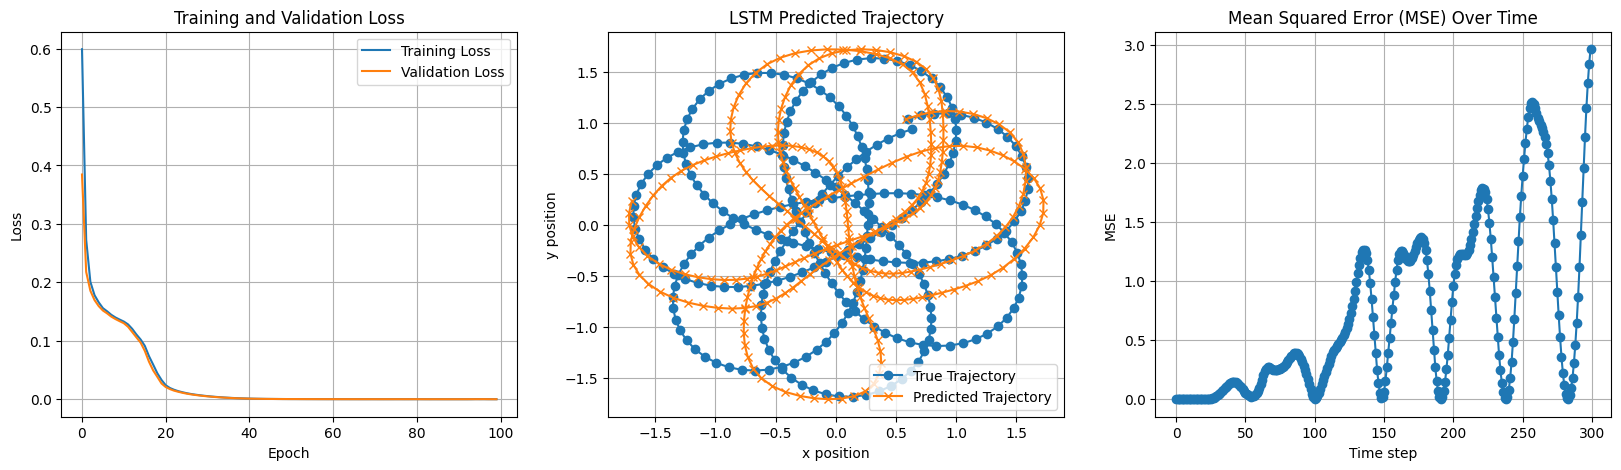

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders_LSTM
from src.network import RecurrentNN
from train import train_model, evaluate_model
from tqdm.auto import tqdm
from plotting import extract_initial_state_and_true_positions_LSTM, plot_predicted_trajectories_LSTM

batch_size = 64
num_epochs = 100
seq_length = 16  # Single step sequence

# initialize figures for plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Get dataloaders
train_loader, test_loader = get_dataloaders_LSTM(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt", seq_length=seq_length)

# Instantiate the LSTM model, define loss function and optimizer
rnn_model = RecurrentNN(input_size=4, hidden_size=64, output_size=4, num_layers=4)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Train the LSTM model
train_model(rnn_model, train_loader,test_loader, criterion, optimizer, ax1, num_epochs=num_epochs)
# Evaluate the LSTM model
evaluate_model(rnn_model, test_loader, criterion)

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions_LSTM(test_loader, steps=300)

# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories_LSTM(rnn_model, initial_state, true_positions, 'LSTM Predicted Trajectory', ax2, steps=300)

# Calculate and plot mean squared error (MSE) as a function of time
# mse = np.mean((true_positions - predicted_positions) ** 2, axis=1)
mse = np.mean((np.array(np.subtract(true_positions,predicted_positions))) ** 2, axis=1)

ax3.plot(mse, marker='o')
ax3.set_title('Mean Squared Error (MSE) Over Time')
ax3.set_xlabel('Time step')
ax3.set_ylabel('MSE')
ax3.grid(True)
plt.show()



## Physics informed Feed Forward NN

Training standard NN


  0%|          | 0/250 [00:00<?, ?it/s]

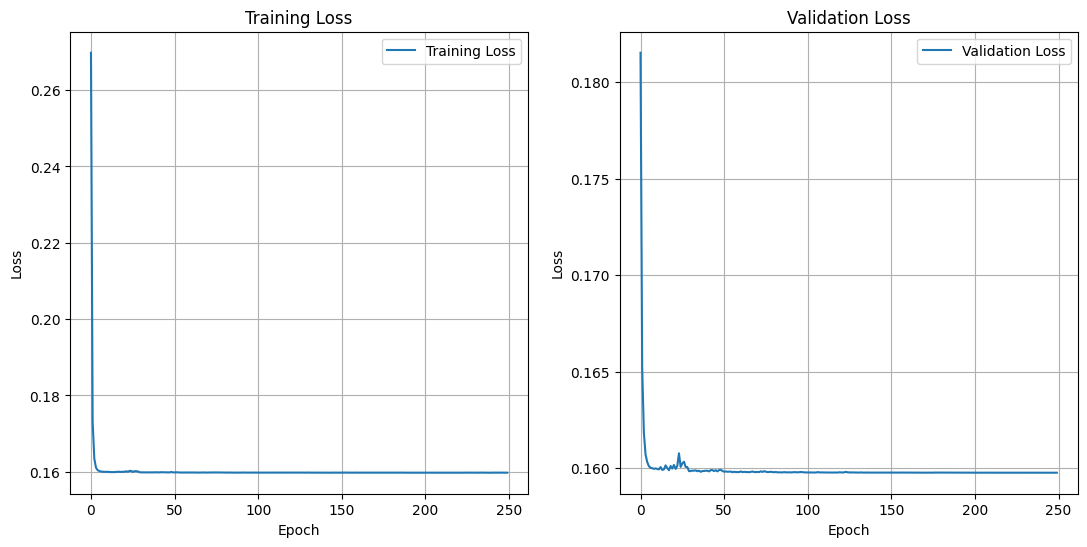

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import FeedForwardNN
from train import train_model, evaluate_model
from tqdm.auto import tqdm
import torch.autograd as ag

epochs = 250 # 1000
n_data = 300
batch_size=64

# Set network size
n_in = 4  # 2 channels position and 2 channels velocity
n_h1 = 100
n_h2 = 50
n_o = 4  # 2 channels for position and 2 channels for velocity at next time step

# Get dataloaders
train_loader, test_loader = get_dataloaders(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt")

# Define the physics-informed neural network
class PINNModel(nn.Module):
    def __init__(self, n_in, n_h1, n_h2, n_o):
        super(PINNModel, self).__init__()
        self.fc1 = nn.Linear(n_in, n_h1)
        self.fc2 = nn.Linear(n_h1, n_h2)
        self.fc3 = nn.Linear(n_h2, n_o)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

    def calculate_step(self, input_states):
        batch_size = input_states.size(0)
        m = 1
        q = 1
        
        x = input_states[:, 2:4]
        v = input_states[:, 0:2]
        
        B_x = torch.zeros(batch_size, 2)
        B_x = torch.cat((B_x, torch.sqrt(x[:, 0]**2 + x[:, 1]**2).view(-1, 1)), 1).view(-1, 1, 3)
        
        B_hat = torch.zeros((B_x.shape[0], 3, 3))
        
        B_hat[:, 0, 1] = -B_x[:, 0, 2]
        B_hat[:, 0, 2] = B_x[:, 0, 1]
        B_hat[:, 1, 2] = -B_x[:, 0, 0]
        
        B_hat[:, 1, 0] = B_x[:, 0, 2]
        B_hat[:, 2, 0] = -B_x[:, 0, 1]
        B_hat[:, 2, 1] = B_x[:, 0, 0]
        
        deltaH = torch.zeros(batch_size, 6)
        deltaH[:, 3] = m * v[:, 0]
        deltaH[:, 4] = m * v[:, 1]
        deltaH[:, 0] = -q * x[:, 0] / 100 / torch.sqrt(x[:, 0]**2 + x[:, 1]**2) ** 3
        deltaH[:, 1] = -q * x[:, 1] / 100 / torch.sqrt(x[:, 0]**2 + x[:, 1]**2) ** 3

        vx_matrix = torch.zeros((batch_size, 6, 6))
        vx_matrix[:, 0:3, 0:3] = -q / m**2 * B_hat
        vx_matrix[:, 0:3, 3:6] = -1 / m * torch.eye(3).unsqueeze(0).expand(batch_size, 3, 3)
        vx_matrix[:, 3:6, 0:3] = 1 / m * torch.eye(3).unsqueeze(0).expand(batch_size, 3, 3)
        
        dvdx = torch.einsum('ijk,ik->ij', vx_matrix, deltaH)
        
        return dvdx

model = PINNModel(n_in, n_h1, n_h2, n_o)

# Set up and train the unconstrained model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10,
                                                       min_lr=1e-10,
                                                       factor=0.5,
                                                       cooldown=15)

criterion = nn.MSELoss()

def train(epoch):
    model.train()
    total_loss = 0
    n_batches = 0
    for input_states, output_states in train_loader:
        optimizer.zero_grad()
        
        x_train = input_states
        yhat = model(x_train)
        
        y_train = output_states

        dvdx = model.calculate_step(input_states)
        
        loss = criterion(y_train, yhat) + criterion(x_train + dvdx[:, [0, 1, 3, 4]], yhat)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.cpu()
        n_batches += 1
    return total_loss / n_batches

def eval(epoch):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        n_batches = 0
        for input_states, output_states in test_loader:
            yhat = model(input_states)
            dvdx = model.calculate_step(input_states)
            loss = criterion(output_states, yhat) + criterion(input_states + dvdx[:, [0, 1, 3, 4]], yhat)
            total_loss += loss.cpu()
            n_batches += 1
    return total_loss / n_batches

train_loss = np.empty([epochs, 1])
val_loss = np.empty([epochs, 1])

print('Training standard NN')

progress_bar = tqdm(range(epochs))

for epoch in progress_bar:
    train_loss[epoch] = train(epoch).detach().numpy()
    v_loss = eval(epoch)
    scheduler.step(v_loss)
    val_loss[epoch] = v_loss.detach().numpy()
    progress_bar.set_description(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss[epoch][0]:.4f}, Validation Loss: {val_loss[epoch][0]:.4f}')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# Plot training loss in the first subplot
ax1.plot(train_loss, label='Training Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot validation loss in the second subplot
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Show the figure
plt.show()


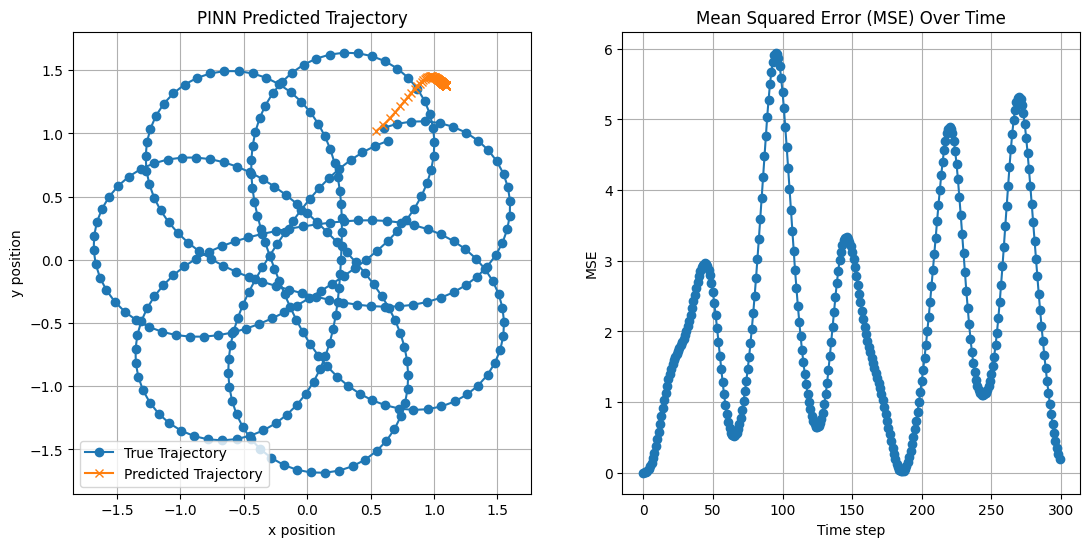

In [40]:
from plotting import plot_predicted_trajectories, extract_initial_state_and_true_positions

# initialize figures for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions(test_loader, steps=300)

# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories(model, initial_state, true_positions, 'PINN Predicted Trajectory', ax1, steps=300)

# Calculate and plot mean squared error (MSE) as a function of time
mse = torch.mean((true_positions - torch.tensor(predicted_positions)) ** 2, axis=1)

ax2.plot(mse, marker='o')
ax2.set_title('Mean Squared Error (MSE) Over Time')
ax2.set_xlabel('Time step')
ax2.set_ylabel('MSE')
ax2.grid(True)
plt.show()

# it should be so bad, but try it for q and m


## Raj feedback


dont use rnn besause of eploding grdaient lstm, 

use simplictic NN

VPT - check in simpnet paper

Hamiltoninan system - no right deffinition of the long time

## Symplectic-Neural-Networks-(SympNet):-Pendulum-System

Training...
0        Train loss: 0.008960857923365434     Test loss: 0.008958109268352282     
1000     Train loss: 0.0009973716129678433    Test loss: 0.0009955958210678855    
2000     Train loss: 0.0009775666261854208    Test loss: 0.0009759939357841408    
3000     Train loss: 0.0009491325259948297    Test loss: 0.0009478147836116439    
4000     Train loss: 0.0009220980543967341    Test loss: 0.0009213973310187736    
5000     Train loss: 0.0008929111125740174    Test loss: 0.0008927125144316291    
6000     Train loss: 0.0008815535296599137    Test loss: 0.0008813740619354033    
7000     Train loss: 0.0008801404586964462    Test loss: 0.0008801240953259447    
8000     Train loss: 0.0008795219958053315    Test loss: 0.000879596954133378     
9000     Train loss: 0.0008788325840777225    Test loss: 0.0008790305786364184    
10000    Train loss: 0.0008782616125096195    Test loss: 0.0008784956576599833    
Done!
'run' took 30.677229404449463 s
Best model at iteration 10000:
Train 

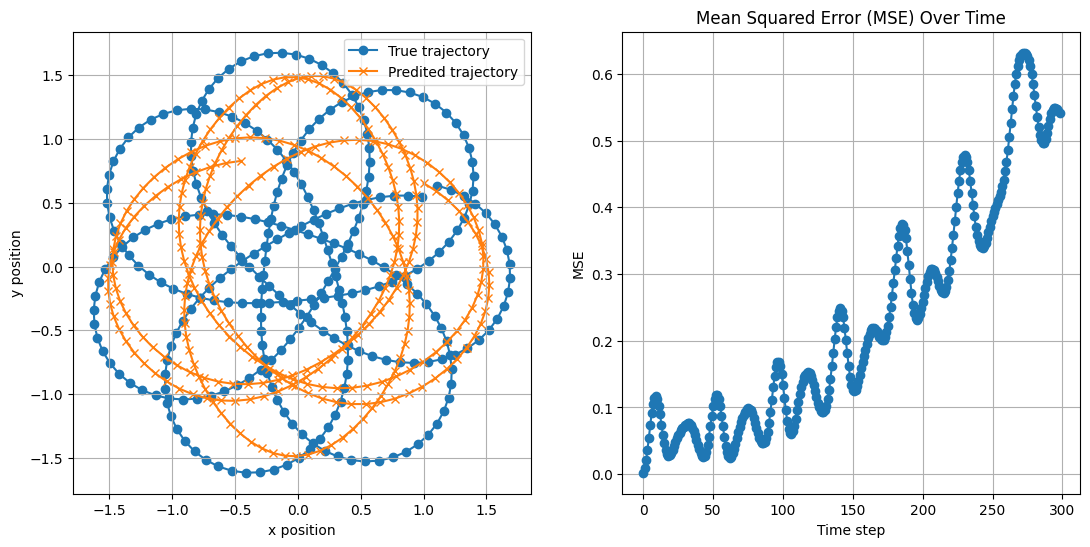

In [52]:
import numpy as np
import matplotlib.pyplot as plt

import learner_SympNet as ln
from learner_SympNet.integrator.hamiltonian import SV

from src.dataset import get_data_SimpNet

DIM=4

class PDData(ln.Data):
    def __init__(self, x0, h, train_num, test_num, add_h=False):
        super(PDData, self).__init__()
        # self.dH = callculateStep
        # self.solver = SV(None, self.dH, iterations=1, order=6, N=10)
        # self.x0 = x0
        self.h = h
        self.train_num = train_num
        self.test_num = test_num
        self.add_h = add_h
        self.__init_data()
        
    @property
    def dim(self):
        return DIM
    
    # def __generate_flow(self, x0, h, num):
    #     X = self.solver.flow(np.array(x0), h, num)
    #     x, y = X[:-1], X[1:]
    #     if self.add_h:
    #         x = np.hstack([x, self.h * np.ones([x.shape[0], 1])])
    #     return x, y
    
    def __init_data(self):
        train_input_sequences, train_output_sequences, _, _  = get_data_SimpNet("data_lorentz/train.txt", "data_lorentz/test.txt")
        
        self.X_train = train_input_sequences[:1200,:] 
        self.y_train = train_output_sequences[:1200,:]
        self.X_test = train_input_sequences[1200:,:] 
        self.y_test = train_output_sequences[1200:,:]
        
        if self.add_h:
            self.X_train = np.hstack([self.X_train, self.h * np.ones([self.X_train.shape[0], 1])])
            self.X_test = np.hstack([self.X_test, self.h * np.ones([self.X_test.shape[0], 1])])
        

def plot(data, net):
    steps = data.y_test.shape[0]
    if isinstance(net, ln.nn.HNN):
        flow_true = data.y_test
        # data.solver.flow(data.X_test_np[0][:-1], data.h, steps)
        flow_pred = net.predict(data.X_test[0, :-1], data.h, steps, keepinitx=True, returnnp=True)
        # flow_pred = net.predict(data.X_test[0][:-1], data.h, steps, keepinitx=True, returnnp=True)
    else:
        flow_true = data.y_test
        # data.solver.flow(data.X_test_np[0], data.h, steps)
        flow_pred = net.predict(data.X_test[0], steps, keepinitx=True, returnnp=True)
    
    
    # initialize figures for plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    
    ax1.plot(flow_true[:, 2], flow_true[:, 3], marker='o', label='True trajectory', zorder=0)
    ax1.plot(flow_pred[:, 2], flow_pred[:, 3], marker='x',  label='Predited trajectory', zorder=1)
    # plt.scatter(data.X_train_np[:, 0], data.X_train_np[:, 1], color='b', label='Learned data', zorder=2)
    ax1.grid(True)
    ax1.set_xlabel("x position")
    ax1.set_ylabel("y position")
    ax1.legend()

    mse = torch.mean((flow_true - torch.tensor(flow_pred[1:])) ** 2, axis=1)

    ax2.plot(mse, marker='o')
    ax2.set_title('Mean Squared Error (MSE) Over Time')
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('MSE')
    ax2.grid(True)
    plt.show()

    


def main():
    device = 'cpu' # 'cpu' or 'gpu'
    # data
    x0 = [0, 1]
    h = 3
    train_num = 1200
    test_num = 300
    # net
    net_type = 'LA' # 'LA' or 'G' or 'HNN'
    LAlayers = 3
    LAsublayers = 2
    Glayers = 5
    Gwidth = 30
    activation = 'sigmoid'
    Hlayers = 4
    Hwidth = 30
    Hactivation = 'tanh'
    # training
    lr = 0.001
    iterations = 10000 #50000
    print_every = 1000
    
    add_h = True if net_type == 'HNN' else False
    criterion = None if net_type == 'HNN' else 'MSE'
    data = PDData(x0, h, train_num, test_num, add_h)
    if net_type == 'LA':
        net = ln.nn.LASympNet(data.dim, LAlayers, LAsublayers, activation)
    elif net_type == 'G':
        net = ln.nn.GSympNet(data.dim, Glayers, Gwidth, activation)
    elif net_type == 'HNN':
        net = ln.nn.HNN(data.dim, Hlayers, Hwidth, Hactivation)
    args = {
        'data': data,
        'net': net,
        'criterion': criterion,
        'optimizer': 'adam',
        'lr': lr,
        'iterations': iterations,
        'batch_size': None,
        'print_every': print_every,
        'save': True,
        'callback': None,
        'dtype': 'double',
        'device': device
    }
    
    ln.Brain.Init(**args)
    ln.Brain.Run()
    ln.Brain.Restore()
    ln.Brain.Output()
    
    plot(data, ln.Brain.Best_model())
    
if __name__ == '__main__':
    main()

## Poisson neural network with NICE

Training...
0        Train loss: 0.0073433625511825085    Test loss: 0.0073435744270682335    


1000     Train loss: 0.0003665104741230607    Test loss: 0.00036694391747005284   
2000     Train loss: 7.83954092185013e-05     Test loss: 7.919772178865969e-05    
3000     Train loss: 5.634734407067299e-05    Test loss: 5.6024753575911745e-05   
4000     Train loss: 3.1051116820890456e-05   Test loss: 3.1572744774166495e-05   
5000     Train loss: 2.4757697246968746e-05   Test loss: 2.6437621272634715e-05   
6000     Train loss: 1.845556471380405e-05    Test loss: 2.0533998394967057e-05   
7000     Train loss: 1.3834558558301069e-05   Test loss: 1.6056665117503144e-05   
8000     Train loss: 1.2664677342399955e-05   Test loss: 1.4977862520026974e-05   
9000     Train loss: 1.017010163195664e-05    Test loss: 1.247493037226377e-05    
10000    Train loss: 1.0966439731419086e-05   Test loss: 1.3223921996541321e-05   
11000    Train loss: 8.381713087146636e-06    Test loss: 1.054893982654903e-05    
12000    Train loss: 7.74126237956807e-06     Test loss: 9.816922101890668e-06    
1300

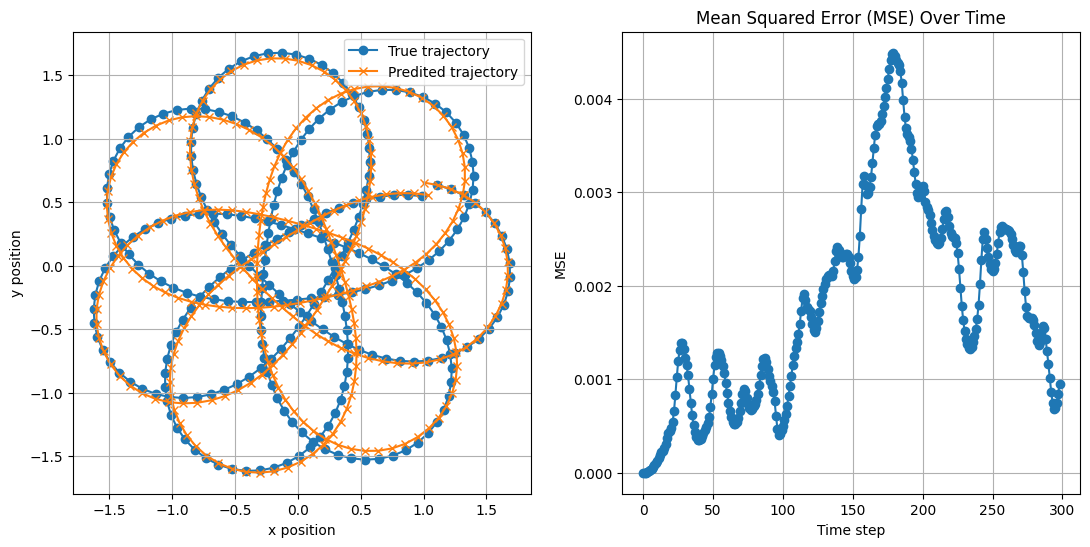

In [5]:
"""
@author: jpzxshi
"""
import numpy as np
import learner_pnn as ln
# FIXME:
# from data import LVData, PDData, LFData, ALData, TBData
from src.postprocess import LV_plot, PD_plot, LF_plot, AL_plot, TB_plot
from src.dataset import get_data_SimpNet

DIM = 4

class PDData(ln.Data):
    def __init__(self, x0, h, train_num, test_num, add_h=False):
        super(PDData, self).__init__()
        # self.dH = callculateStep
        # self.solver = SV(None, self.dH, iterations=1, order=6, N=10)
        # self.x0 = x0
        self.h = h
        self.train_num = train_num
        self.test_num = test_num
        self.add_h = add_h
        self.__init_data()
        
    @property
    def dim(self):
        return DIM
    @property
    def latent_dim(self):
        return 2
    # def __generate_flow(self, x0, h, num):
    #     X = self.solver.flow(np.array(x0), h, num)
    #     x, y = X[:-1], X[1:]
    #     if self.add_h:
    #         x = np.hstack([x, self.h * np.ones([x.shape[0], 1])])
    #     return x, y
    
    def __init_data(self):
        train_input_sequences, train_output_sequences, _, _  = get_data_SimpNet("data_lorentz/train.txt", "data_lorentz/test.txt")
        
        self.X_train = train_input_sequences[:1200,:] 
        self.y_train = train_output_sequences[:1200,:]
        self.X_test = train_input_sequences[1200:,:] 
        self.y_test = train_output_sequences[1200:,:]
        
        if self.add_h:
            self.X_train = np.hstack([self.X_train, self.h * np.ones([self.X_train.shape[0], 1])])
            self.X_test = np.hstack([self.X_test, self.h * np.ones([self.X_test.shape[0], 1])])


def PD():
    device = 'cpu' # 'cpu' or 'gpu'
    # data
    z0 = [1, 0.5, 0.5, 1]
    h = 0.1
    train_num = 1500
    test_num = 300
    # PNN
    inn_volume_preserving = True
    inn_layers = 10
    inn_sublayers = 3
    inn_subwidth = 50
    inn_activation = 'sigmoid'
    symp_type = 'G' # 'LA' or 'G'
    symp_LAlayers = 3
    symp_LAsublayers = 2
    symp_Glayers = 10
    symp_Gwidth = 50
    symp_activation = 'sigmoid'
    # training
    lr = 0.001
    iterations = 30000
    print_every = 1000
    
    data = PDData(z0, h, train_num, test_num)
    inn = ln.nn.INN(data.dim, data.dim // 2, inn_layers, inn_sublayers, inn_subwidth, inn_activation, 
                    volume_preserving=inn_volume_preserving)
    if symp_type == 'LA':
        sympnet = ln.nn.LASympNet(data.dim, symp_LAlayers, symp_LAsublayers, symp_activation)
    elif symp_type == 'G':
        sympnet = ln.nn.GSympNet(data.dim, symp_Glayers, symp_Gwidth, symp_activation)
    net = ln.nn.PNN(inn, sympnet)
    args = {
        'data': data,
        'net': net,
        'criterion': 'MSE',
        'optimizer': 'adam',
        'lr': lr,
        'iterations': iterations,
        'batch_size': None,
        'print_every': print_every,
        'save': True,
        'callback': None,
        'dtype': 'float',
        'device': device
    }
    
    ln.Brain.Init(**args)
    ln.Brain.Run()
    ln.Brain.Restore()
    ln.Brain.Output()
    
    PD_plot(data, ln.Brain.Best_model())


def main():
    PD()
    
if __name__ == '__main__':
    main()

## PINN estimation of m and q - m and q are outputs

Training standard NN


  0%|          | 0/10 [00:00<?, ?it/s]

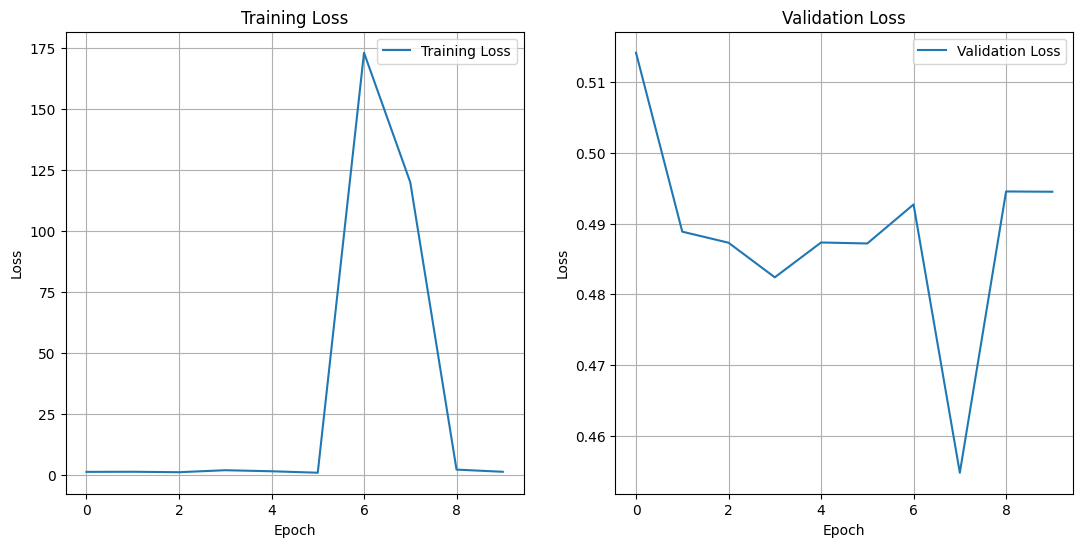

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import FeedForwardNN
from train import train_model, evaluate_model
from tqdm.auto import tqdm
import torch.autograd as ag

epochs = 250 #1000
epochs = 10
n_data = 300
batch_size=64

## ------------------ set up models-------------------------- ##
# set network size
n_in = 4 # 2 channels position and 2 channels velocity
n_h1 = 100
n_h2 = 50
n_o = 2 # 2 channels for m and q

# Get dataloaders
train_loader, test_loader = get_dataloaders(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt")

# Define the physics-informed neural network
model = torch.nn.Sequential(
    torch.nn.Linear(n_in, n_h1),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h1, n_h2),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h2, n_o),
)


# ---------------  Set up and train the uncconstrained model -------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10,
                                                     min_lr=1e-10,
                                                    factor=0.5,
                                                    cooldown=15)

criterion=nn.MSELoss()

def callculateStep(input_states, m, q):
    
    batch_size = input_states.size(0)
    x = input_states[:, 0:2]
    v = input_states[:, 2:4]
    
    B_x = torch.zeros(batch_size, 2)
    B_x = torch.cat((B_x, torch.sqrt(x[:, 0]**2 + x[:, 1]**2).view(-1,1)),1).view(-1,1,3)

    B_hat = torch.zeros((B_x.shape[0], 3, 3))
    
    B_hat[:,0,1] = - B_x[:,0,2]
    B_hat[:,0,2] = B_x[:,0,1]
    B_hat[:,1,2] = - B_x[:,0,0]
    
    B_hat[:,1,0] = B_x[:,0,2]
    B_hat[:,2,0] = - B_x[:,0,1]
    B_hat[:,2,1] = B_x[:,0,0]

    
    deltaH = torch.zeros(batch_size, 6)
    deltaH[:,3] = m * v[:,0]
    deltaH[:,4] = m * v[:,1]

    deltaH[:,0] = - q * x[:,0]/100 / torch.sqrt(x[:,0]**2 + x[:,1]**2) **3
    deltaH[:,1] = - q * x[:,1]/100 / torch.sqrt(x[:,0]**2 + x[:,1]**2) **3

    vx_matrix = torch.zeros((batch_size, 6, 6))
    vx_matrix[:,0:3,0:3] = -q/m**2 * B_hat
    vx_matrix[:,0:3,3:6] = -1/m *torch.eye(3).unsqueeze(0).expand(batch_size, 3, 3) 
    vx_matrix[:,3:6,0:3] = 1/m * torch.eye(3).unsqueeze(0).expand(batch_size, 3, 3)

    dvdx = torch.einsum('ijk,ik->ij',vx_matrix, deltaH)
    
    return dvdx  

def train(epoch):
    model.train()
    total_loss = 0
    n_batches = 0
    for input_states, output_states in train_loader:
        optimizer.zero_grad()
        
        x_train = input_states
        mq = model(x_train)
        
        y_train = output_states

        dvdx = callculateStep(input_states, torch.mean(mq[0]),torch.mean(mq[1]))
        
        loss = criterion(x_train+dvdx[:, [0,1,3,4] ], y_train)


        loss.backward()
        optimizer.step()
        total_loss += loss.cpu()
        n_batches += 1
    return total_loss / n_batches

def eval(epoch):
    model.eval()
    for input_states, output_states in test_loader:
        with torch.no_grad():
            mq = model(input_states)
            dvdx = callculateStep(input_states, torch.mean(mq[0]),torch.mean(mq[1]))
            loss = criterion(input_states+dvdx[:, [0,1,3,4] ], output_states)
    return loss.cpu()


train_loss = np.empty([epochs, 1])
val_loss = np.empty([epochs, 1])


print('Training standard NN')

progress_bar = tqdm(range(epochs))    

for epoch in progress_bar:
    train_loss[epoch] = train(epoch).detach().numpy()
    v_loss = eval(epoch)
    scheduler.step(v_loss)
    val_loss[epoch] = v_loss.detach().numpy()
    progress_bar.set_description(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss[epoch][0]:.4f}, Validation Loss: {val_loss[epoch][0]:.4f}')
    

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# Plot training loss in the first subplot
ax1.plot(train_loss, label='Training Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot validation loss in the second subplot
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Show the figure
plt.show()


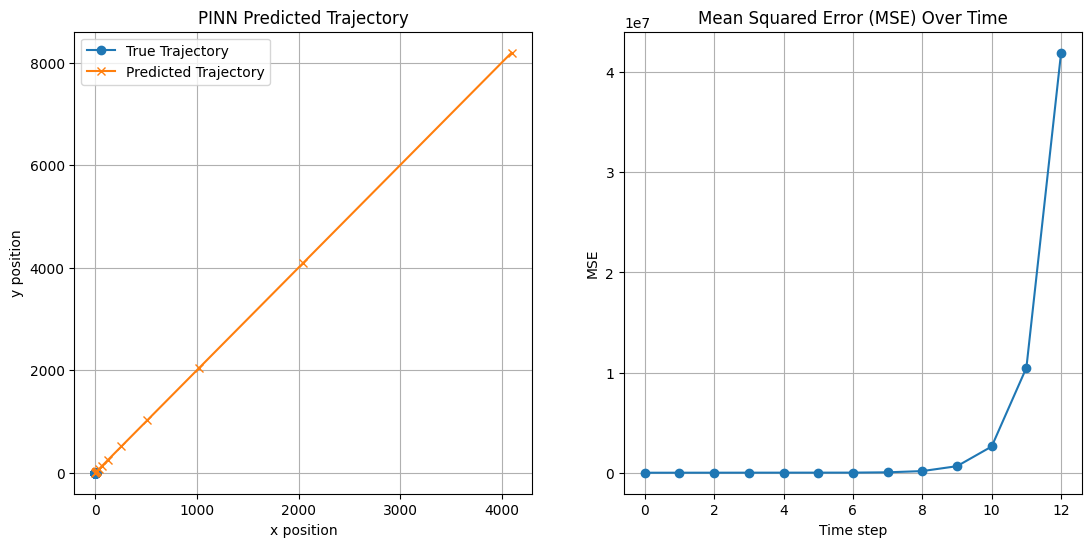

In [2]:
from plotting import extract_initial_state_and_true_positions, plot_predicted_trajectories_PINN_mp

# initialize figures for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions(test_loader, steps=300)

# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories_PINN_mp(model, callculateStep, initial_state, true_positions, 'PINN Predicted Trajectory', ax1, steps=300)

# Calculate and plot mean squared error (MSE) as a function of time
mse = torch.mean((true_positions - torch.tensor(predicted_positions[:,:2])) ** 2, axis=1)

ax2.plot(mse, marker='o')
ax2.set_title('Mean Squared Error (MSE) Over Time')
ax2.set_xlabel('Time step')
ax2.set_ylabel('MSE')
ax2.grid(True)
plt.show()

## PINN estimation and automatic differntiation

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders, get_PINN_dataloaders
from src.network import FeedForwardNN
from train import train_model, evaluate_model
from tqdm.auto import tqdm
import torch.autograd as ag

epochs = 250 # 1000
# epochs=25
n_data = 300
batch_size=128

# Set network size
n_in = 1  # 2 channels position and 2 channels velocity
n_h1 = 64
n_h2 = 64
n_o = 4  # 2 channels for position and 2 channels for velocity at next time step

# Get dataloaders
train_loader, test_loader = get_PINN_dataloaders(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt")

# Define the physics-informed neural network
class PINNModel(nn.Module):
    def __init__(self, n_in, n_h1, n_h2, n_o):
        super(PINNModel, self).__init__()
        self.fc1 = nn.Linear(n_in, n_h1)
        self.fc2 = nn.Linear(n_h1, n_h2)
        self.fc3 = nn.Linear(n_h2, n_o)
        self.tanh = nn.Tanh()
        self.q = nn.Parameter(torch.tensor(1.0))  # Initialize q as a learnable parameter
        self.m = nn.Parameter(torch.tensor(1.0))  # Initialize m as a learnable parameter

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def hamiltonian(self, x, v):
        kinetic = 0.5 * self.m * torch.sum(v**2, dim=1)
        potential = self.q / 100 / torch.sqrt(x[:, 0]**2 + x[:, 1]**2)
        return kinetic + potential
    
    def calculate_step_analytical(self, input_states):
        batch_size = input_states.size(0)
        x = input_states[:, 2:4]
        v = input_states[:, 0:2]
        
        B_x = torch.zeros(batch_size, 2)
        B_x = torch.cat((B_x, torch.sqrt(x[:, 0]**2 + x[:, 1]**2).view(-1, 1)), 1).view(-1, 1, 3)
        
        B_hat = torch.zeros((B_x.shape[0], 3, 3))
        
        B_hat[:, 0, 1] = -B_x[:, 0, 2]
        B_hat[:, 0, 2] = B_x[:, 0, 1]
        B_hat[:, 1, 2] = -B_x[:, 0, 0]
        
        B_hat[:, 1, 0] = B_x[:, 0, 2]
        B_hat[:, 2, 0] = -B_x[:, 0, 1]
        B_hat[:, 2, 1] = B_x[:, 0, 0]
        
        deltaH = torch.zeros(batch_size, 6)
        deltaH[:, 3] = self.m * v[:, 0]
        deltaH[:, 4] = self.m * v[:, 1]
        deltaH[:, 0] = -self.q * x[:, 0] / 100 / torch.sqrt(x[:, 0]**2 + x[:, 1]**2) ** 3
        deltaH[:, 1] = -self.q * x[:, 1] / 100 / torch.sqrt(x[:, 0]**2 + x[:, 1]**2) ** 3

        vx_matrix = torch.zeros((batch_size, 6, 6))
        vx_matrix[:, 0:3, 0:3] = -self.q / self.m**2 * B_hat
        vx_matrix[:, 0:3, 3:6] = -1 / self.m * torch.eye(3).unsqueeze(0).expand(batch_size, 3, 3)
        vx_matrix[:, 3:6, 0:3] = 1 / self.m * torch.eye(3).unsqueeze(0).expand(batch_size, 3, 3)
        
        dvdx = torch.einsum('ijk,ik->ij', vx_matrix, deltaH)
        
        return dvdx

    def calculate_step_autograd(self, input_states):
        batch_size = input_states.size(0)
        x = input_states[:, 2:4]
        v = input_states[:, 0:2]

        # Calculate B(x)
        B_x = torch.zeros(batch_size, 2)
        B_x = torch.cat((B_x, torch.sqrt(x[:, 0]**2 + x[:, 1]**2).view(-1, 1)), 1).view(-1, 1, 3)
        
        B_hat = torch.zeros((B_x.shape[0], 3, 3))
        
        B_hat[:, 0, 1] = -B_x[:, 0, 2]
        B_hat[:, 0, 2] = B_x[:, 0, 1]
        B_hat[:, 1, 2] = -B_x[:, 0, 0]
        
        B_hat[:, 1, 0] = B_x[:, 0, 2]
        B_hat[:, 2, 0] = -B_x[:, 0, 1]
        B_hat[:, 2, 1] = B_x[:, 0, 0]

        x = torch.cat([x, torch.zeros(batch_size, 1)], dim=1)
        v = torch.cat([v, torch.zeros(batch_size, 1)], dim=1)

        x.requires_grad_(True)
        v.requires_grad_(True)

        # Hamiltonian
        H = self.hamiltonian(x[:, :2], v[:, :2])#.unsqueeze(-1)
        # H.requires_grad_(True)

        dH_dv = torch.zeros_like(v)
        dH_dx = torch.zeros_like(x)
        grad_H = ag.grad(H, (v, x), create_graph=True, allow_unused=True, retain_graph=True)
        dH_dv = grad_H[0]
        dH_dx = grad_H[1]

        # Concatenate gradients to match deltaH shape
        deltaH = torch.zeros(batch_size, 6)
        deltaH[:, :3] = dH_dv
        deltaH[:, 3:] = dH_dx

        # vx_matrix construction
        vx_matrix = torch.zeros((batch_size, 6, 6))
        vx_matrix[:, 0:3, 0:3] = -self.q / self.m**2 * B_hat
        vx_matrix[:, 0:3, 3:6] = -1 / self.m * torch.eye(3).unsqueeze(0).expand(batch_size, 3, 3)
        vx_matrix[:, 3:6, 0:3] = 1 / self.m * torch.eye(3).unsqueeze(0).expand(batch_size, 3, 3)

        # Calculate dvdx
        dvdx = torch.einsum('ijk,ik->ij', vx_matrix, deltaH)

        return dvdx

model = PINNModel(n_in, n_h1, n_h2, n_o)

# Set up and train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

def train(epoch):
    model.train()
    total_loss = 0
    n_batches = 0
    for input_t, output_states in train_loader:
        optimizer.zero_grad()
        
        x_train = input_t
        y_train = output_states

        yhat = model(x_train)

        dvdx = model.calculate_step_autograd(yhat)
        dvdx_an = model.calculate_step_analytical(yhat)
        
        loss1 = criterion(y_train, yhat)
        loss2 = criterion(dvdx[:, [0, 1, 3, 4]], dvdx_an[:, [0, 1, 3, 4]])
        
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        total_loss += loss.cpu()
        n_batches += 1
    return total_loss / n_batches

def eval(epoch):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        n_batches = 0
        for input_t, output_states in test_loader:
            x_train = input_t
            y_train = output_states
            yhat = model(input_t)
            dvdx = model.calculate_step_analytical(yhat)
            dvdx_an = model.calculate_step_analytical(yhat)
            loss1 = criterion(y_train, yhat)
            loss2 = criterion(dvdx[:, [0, 1, 3, 4]], dvdx_an[:, [0, 1, 3, 4]])
            loss = loss1 + loss2
            total_loss += loss.cpu()
            n_batches += 1
    return total_loss / n_batches

train_loss = np.empty([epochs, 1])
val_loss = np.empty([epochs, 1])

print('Training standard NN')

progress_bar = tqdm(range(epochs))

for epoch in progress_bar:
    train_loss[epoch] = train(epoch).detach().numpy()
    v_loss = eval(epoch)
    val_loss[epoch] = v_loss.detach().numpy()
    progress_bar.set_description(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss[epoch][0]:.4f}, Validation Loss: {val_loss[epoch][0]:.4f}')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# Plot training loss in the first subplot
ax1.plot(train_loss, label='Training Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot validation loss in the second subplot
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Show the figure
plt.show()


  0%|          | 0/250 [00:00<?, ?it/s]

TypeError: jacobian() got an unexpected keyword argument 'retain_graph'

IndexError: index 0 is out of bounds for dimension 1 with size 0

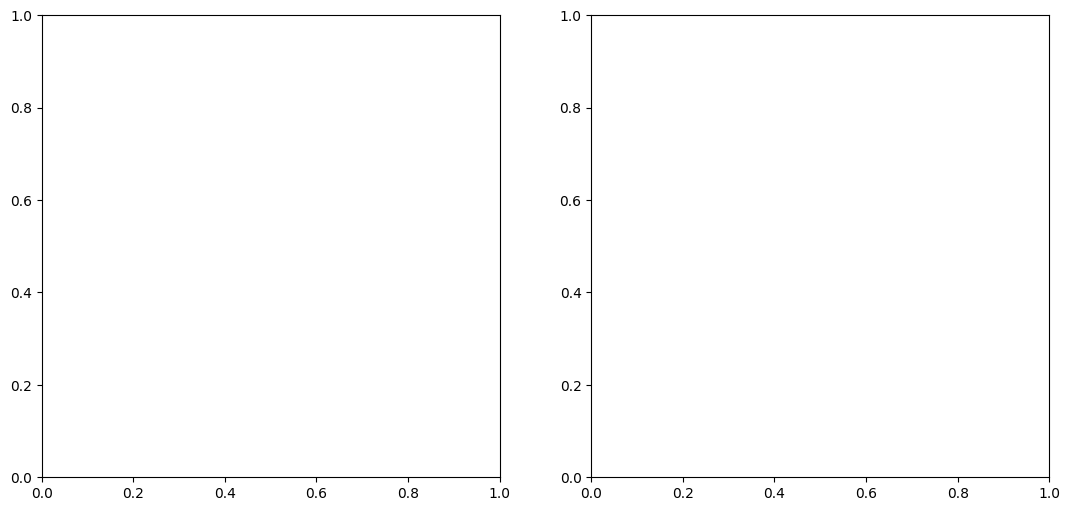

In [17]:
from plotting import extract_initial_state_and_true_positions, plot_predicted_trajectories_PINN

# initialize figures for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions(test_loader, steps=300)

# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories_PINN(model, _, initial_state, true_positions, 'PINN Predicted Trajectory', ax1, steps=300)

# Calculate and plot mean squared error (MSE) as a function of time
mse = torch.mean((true_positions - torch.tensor(predicted_positions[:,:2])) ** 2, axis=1)

ax2.plot(mse, marker='o')
ax2.set_title('Mean Squared Error (MSE) Over Time')
ax2.set_xlabel('Time step')
ax2.set_ylabel('MSE')
ax2.grid(True)
plt.show()

In [36]:
print( torch.tensor(predicted_positions[:,:2]))
print(model.q, model.m)

tensor([[ 4.6422e-01,  9.2845e-01],
        [ 4.2272e-01,  8.4544e-01],
        [ 3.7266e-01,  7.4533e-01],
        [ 3.0826e-01,  6.1652e-01],
        [ 2.1414e-01,  4.2827e-01],
        [ 1.9075e-02,  3.8150e-02],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.9126e+01],
        [-2.4563e+01, -4.912

## Particle motion Doesnt work

In [ ]:
import torch
def calculate_step(input_states):
    batch_size = input_states.size(0)
    m = .01
    q = .01
    
    v = input_states[:, 0:2]
    x = input_states[:, 3:5]
    
    B_x = torch.zeros(batch_size, 2)
    B_x = torch.cat((B_x, torch.sqrt(x[:, 0]**2 + x[:, 1]**2).view(-1, 1)), 1).view(-1, 1, 3)
    
    B_hat = torch.zeros((batch_size, 3, 3))
    
    B_hat[:, 0, 1] = -B_x[:, 0, 2]
    B_hat[:, 0, 2] = B_x[:, 0, 1]
    B_hat[:, 1, 2] = -B_x[:, 0, 0]
    
    B_hat[:, 1, 0] = B_x[:, 0, 2]
    B_hat[:, 2, 0] = -B_x[:, 0, 1]
    B_hat[:, 2, 1] = B_x[:, 0, 0]
    
    deltaH = torch.zeros(batch_size, 6)
    deltaH[:, 3] = m * v[:, 0]
    deltaH[:, 4] = m * v[:, 1]
    deltaH[:, 0] = -q * x[:, 0] / 100 / (x[:, 0]**2 + x[:, 1]**2) ** (3/2)
    deltaH[:, 1] = -q * x[:, 1] / 100 / (x[:, 0]**2 + x[:, 1]**2) ** (3/2)

    vx_matrix = torch.zeros((batch_size, 6, 6))
    vx_matrix[:, 0:3, 0:3] = -q / (m+0.001)**2 * B_hat
    vx_matrix[:, 0:3, 3:6] = -1 / (m+0.001) * torch.eye(3).unsqueeze(0).expand(batch_size, 3, 3)
    vx_matrix[:, 3:6, 0:3] = 1 / (m+0.001) * torch.eye(3).unsqueeze(0).expand(batch_size, 3, 3)
    
    dvdx = torch.einsum('ijk,ik->ij', vx_matrix, deltaH)

    return dvdx

all_steps = torch.empty(0,6)
current_step =torch.tensor([[1,0.5,0,0.5,1,0]])
for step in range(1000):
    next_step = current_step + calculate_step(current_step)*0.1
    all_steps = torch.cat((all_steps, current_step))
    current_step = next_step


# print(all_steps)

plt.plot(all_steps[:,3], all_steps[:,4] )

In [ ]:
plt.plot(all_steps[1:1000,[0,1]])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def calculate_step(input_states):
    batch_size = input_states.shape[0]
    m = .1
    q = .1
    
    v = input_states[:, 0:2]
    x = input_states[:, 3:5]
    
    B_x = np.zeros((batch_size, 2))
    B_x = np.concatenate((B_x, np.sqrt(x[:, 0]**2 + x[:, 1]**2).reshape(-1, 1)), 1).reshape(-1, 1, 3)
    
    B_hat = np.zeros((batch_size, 3, 3))
    
    B_hat[:, 0, 1] = -B_x[:, 0, 2]
    B_hat[:, 0, 2] = B_x[:, 0, 1]
    B_hat[:, 1, 2] = -B_x[:, 0, 0]
    
    B_hat[:, 1, 0] = B_x[:, 0, 2]
    B_hat[:, 2, 0] = -B_x[:, 0, 1]
    B_hat[:, 2, 1] = B_x[:, 0, 0]
    
    deltaH = np.zeros((batch_size, 6))
    deltaH[:, 3] = m * v[:, 0]
    deltaH[:, 4] = m * v[:, 1]
    deltaH[:, 0] = -q * x[:, 0] / 100 / (x[:, 0]**2 + x[:, 1]**2) ** (3/2)
    deltaH[:, 1] = -q * x[:, 1] / 100 / (x[:, 0]**2 + x[:, 1]**2) ** (3/2)

    vx_matrix = np.zeros((batch_size, 6, 6))
    vx_matrix[:, 0:3, 0:3] = -q /( m+0.001)**2 * B_hat
    vx_matrix[:, 0:3, 3:6] = -1 /( m+0.001) * np.eye(3)
    vx_matrix[:, 3:6, 0:3] = 1 / (m +0.001)* np.eye(3)
    
    dvdx = np.einsum('ijk,ik->ij', vx_matrix, deltaH)

    return dvdx

all_steps = np.empty((0,6))
current_step =np.array([[1,0.5,0,0.5,1,0]])
for step in range(100):
    next_step = current_step + calculate_step(current_step)
    all_steps = np.concatenate((all_steps, current_step))
    current_step = next_step


# print(all_steps)

plt.plot(all_steps[:90,3], all_steps[:90,4] )

LFFDATA

In [ ]:
import learner_pnn as ln
from learner_pnn.integrator.hamiltonian import SV

class LFData(   ln.Data):
    '''The two-dimensional dynamics of the charged particle in the electromagnetic field 
    governed by the Lorentz force.
    m * x_tt = q * (E + x_t cross B)
    H(v,x)=v^T*v/2+1/(100*sqrt(x1^2+x2^2)), B(v,x)=[[-B_hat(x), -I], [I, 0]]
    B_hat(x)=[[0, -sqrt(x1^2+x2^2)], [sqrt(x1^2+x2^2), 0]]
    (p,x)=(v+A(x),x), A(x)=sqrt(x1^2+x2^2)/3*(-x2,x1)^T
    K(p,x)=(p-A(x))^T*(p-A(x))/2+1/(100*sqrt(x1^2+x2^2))
    v=(v1, v2), x=(x1, x2), z=(v, x)=(v1, v2, x1, x2)
    '''
    def __init__(self, z0, h, train_num, test_num):
        super(LFData, self).__init__()
        self.z0 = z0
        self.h = h
        self.train_num = train_num
        self.test_num = test_num
        self.q=1    
        self.m=1
        
        self.solver = SV(None, self.dK, iterations=10, order=4, N=max(int(self.h * 1e1), 1))
        self.__init_data()
        
    def dK(self, p, x):
        R = np.linalg.norm(x, axis=-1, keepdims=True)
        A = x @ np.array([[0, 1], [-1, 0]]) * (R / 3)
        dA = np.hstack([
                - x[..., :1] * x[..., 1:],
                - x[..., :1] ** 2 - 2 * x[..., 1:] ** 2,
                2 * x[..., :1] ** 2 + x[..., 1:] ** 2,
                x[..., :1] * x[..., 1:]
                ]) / (R * 3)
        dA = dA.reshape([-1, 2, 2])
        dphi = x / (- 100 * R ** 3)
        dp = self.q/self.m*(p - A)
        dx = self.q**2/self.m**2 * dphi - (np.expand_dims(dp, axis=-2) @ dA).squeeze()
        return dp, dx
    
    def generate_flow(self, z0, h, num):
        z0 = np.array(z0)
        # (v,x) to (p,x)
        v, x = z0[:2], z0[2:]
        p = v + np.array([-x[1], x[0]]) * (np.linalg.norm(x) / 3)
        # solve
        flow = self.solver.flow(np.hstack((p, x)), h, num)
        # (p,x) to (v,x)
        p, x = flow[..., :2], flow[..., 2:]
        v = p - x @ np.array([[0, 1], [-1, 0]]) * (np.linalg.norm(x, axis=-1, keepdims=True) / 3)
        return np.hstack((v, x))
    
    def __init_data(self):
        train_flow = self.generate_flow(self.z0, self.h, self.train_num)
        test_flow = self.generate_flow(train_flow[-1], self.h, self.test_num)
        self.X_train, self.y_train = train_flow[:-1], train_flow[1:]
        self.X_test, self.y_test = test_flow[:-1], test_flow[1:]

z0 = [1, 0.5, 0.5, 1]
h=0.1
train_num = 300
test_num = 300
data = LFData(z0, h, train_num, test_num)

In [ ]:
plt.plot(data.X_train[:,2], data.X_train[:,3])